In [1]:
# THIS IS A NEW BRANCH
# THIS IS AN EDIT ON MAIN BRANCH
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Noise Reduction Methods
import scipy.signal as ss  # Signal processing
from scipy.signal import savgol_filter, wiener
from skimage.restoration import denoise_tv_chambolle, calibrate_denoiser
from skimage.restoration.j_invariant import _invariant_denoise
import pyyawt  # Yet Another Wavelet Transform
import dtcwt  # Dual Tree Continuous Wavelet Transform

from numpy.lib.stride_tricks import as_strided
from functools import partial

# Signal generating functions



In [2]:
# Noise
def add_gwn(clean_signal, sqrt_snr=5, sigma=None):
    """
    Adds Gaussian White Noise to given clean signal
    Parameters
    ----------
    clean_signal: 1D np.array
    sqrt_snr: float
        Desired SNR of clean signal to noisy signal
    sigma: float
        Standard deviation of noise. If provided, adds constant noise of given standard deviation.
        Otherwise, calculates noise standard deviation based on desired SNR
    
    Returns
    -------
    noisy_signal: 1D np.array
        Clean signal with added GWN
    """
    if sigma is None:
        sigma = np.sqrt(np.mean(clean_signal**2)) / sqrt_snr
    mu = 0
    gwn = np.random.default_rng().normal(mu, sigma, size=len(clean_signal))
    return clean_signal + gwn

In [3]:
def generate_test_signals(sig_len=11, sqrt_snr=2):
    """
    Generates clean and noisy test signals of length t and noise given by sqrt_snr.
    Noisy signals are clean signals corrupted with added constant Gaussian white noise
    Parameters
    ----------
    sig_len: int
        Power for dyadic signal length, i.e. len(X) = 2^sig_len
    sqrt_snr: float
        Square root of desired SNR for noise. Lower sqrt_snr means more noise.
        
    Returns
    -------
    t: 1D np.array
        Time vector equivalent to the indices of the signal
    clean_signal: dict
        Dictionary containing clean signals as 1D np.array
    noisy_signal: dict
        Dictionary containing noisy signals as 1D np.array
    """
    noisy_signal = {}
    clean_signal = {}
    t = np.arange(2**sig_len)
    f = len(t)/10000 * 1000
    for sig_name in ['blocks', 'bumps', 'heavy sine']:
        # clean_signal[sig_name], noisy_signal[sig_name] = pyyawt.denoising.wnoise(sig_name, sig_len, SQRT_SNR=sqrt_snr)
        clean, _ = pyyawt.denoising.wnoise(sig_name, sig_len)
        X = clean
        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        clean_scaled = X_std * (1 - (-1)) + (-1)  # Scale to between -1 and 1
        clean_signal[sig_name] = clean_scaled
        noisy_signal[sig_name] = add_gwn(clean_scaled, sqrt_snr=sqrt_snr)
    
    # square_wave
    square_wave = ss.square(2*np.pi/1 * t/f, 0.5)

    # sawtooth_wave
    sawtooth_wave = ss.sawtooth(2*np.pi/2 * t/f, 0.2)

    # simple_sine
    simple_sine = np.sin(2*np.pi/2*t/f)
    
    # sum_sine
    t4 = np.tile(t/f, (4, 1))
    freqs = 2*np.pi*np.array([0.4, 0.7, 1.2, 1.4])
    sum_sine = np.sum(np.sin(freqs * t4.T).T, axis=0)
    sum_sine = sum_sine / np.max(sum_sine, axis=0)

    # poly_cosine
    poly = np.poly1d([0.025, -0.36, 1.25, 2.0])
    poly_cosine = ss.sweep_poly(t/f, poly)
    
    sig_names = ['square_wave', 'sawtooth_wave', 'simple_sine', 'sum_sine', 'poly_cosine']
    signals = [square_wave, sawtooth_wave, simple_sine, sum_sine, poly_cosine]
    for sig_name, signal in zip(sig_names, signals):
        clean_signal[sig_name] = signal
        noisy_signal[sig_name] = add_gwn(signal, sqrt_snr=sqrt_snr)
    return t, clean_signal, noisy_signal

In [4]:
t, clean_sig, noisy_sig = generate_test_signals(sig_len=14, sqrt_snr=8)

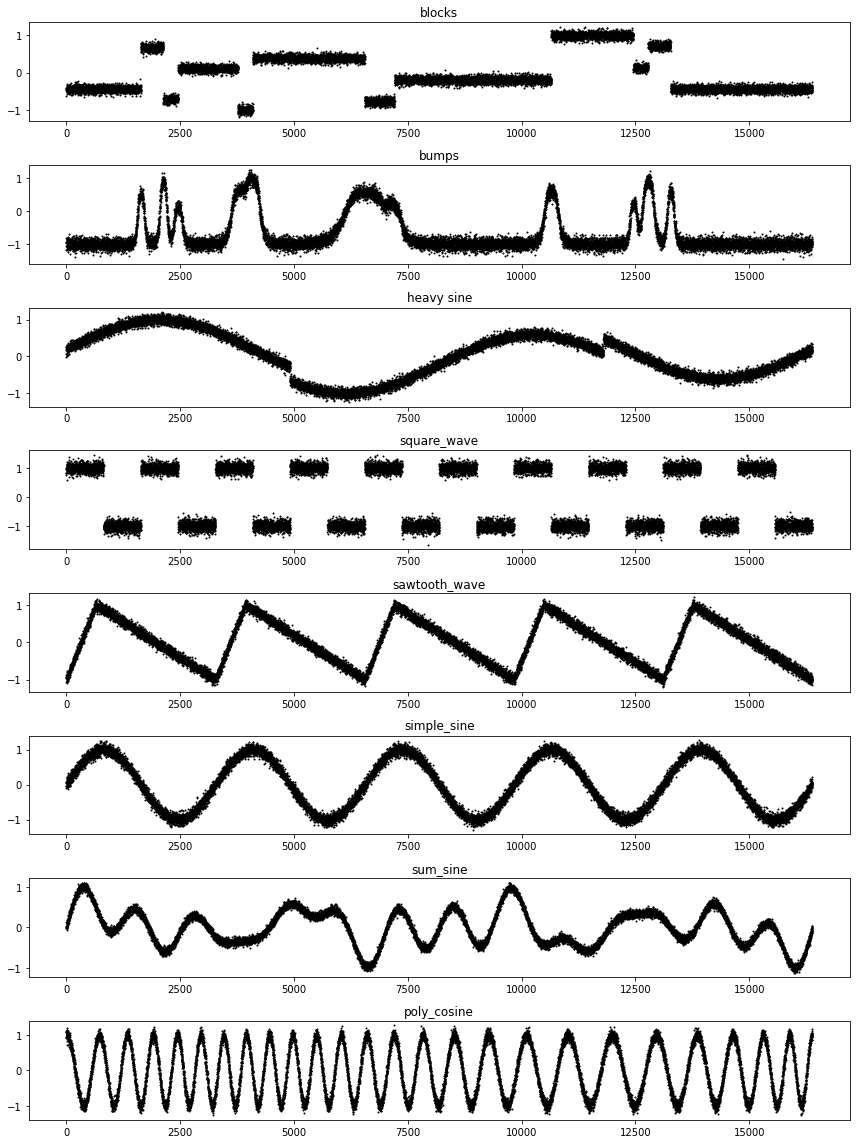

In [5]:
fig, axs = plt.subplots(8, 1, figsize=(12, 16))

for ax, signal in zip(axs, noisy_sig.keys()):
    ax.plot(noisy_sig[signal], 'o', color='k', ms=1)
    ax.set_title(signal)
plt.tight_layout()
plt.show()


In [6]:
noisy_sig.keys()

dict_keys(['blocks', 'bumps', 'heavy sine', 'square_wave', 'sawtooth_wave', 'simple_sine', 'sum_sine', 'poly_cosine'])

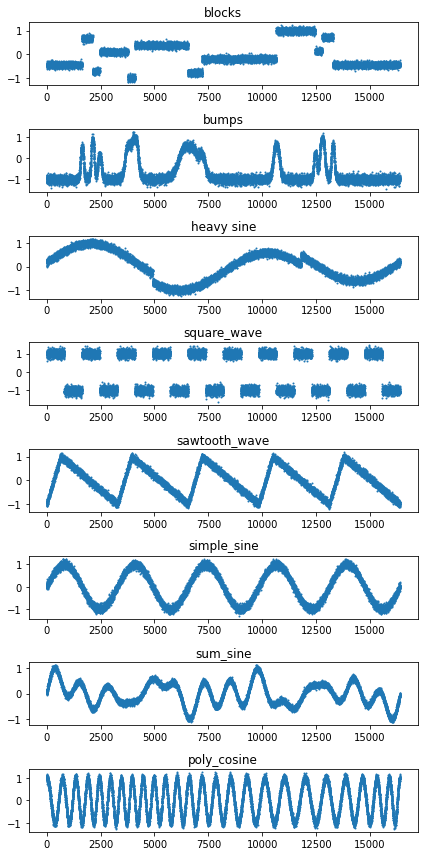

In [7]:
N = len(noisy_sig.keys())

fig, axs = plt.subplots(N, 1, figsize=(6, 12))

for ax, k in zip(axs, noisy_sig.keys()):
    ax.plot(t, noisy_sig[k], 'o', ms=1)
    ax.set_title(k)
plt.tight_layout()
plt.show()

# Denoising Functions

In [8]:
from denoising_functions import *

In [9]:
x = noisy_sig['blocks']

In [10]:
x.shape

(16384,)

In [11]:
# x_den = direct_tvd(x, weight=2)
x_den = DTCWTNeighCoeff(x, nlevels=5)
x_den = wden_softSURE(x, level=5)
x_den = wavelet_denoising(x, level=5)
x_den = denoise_tv_chambolle(x, weight=2)

/home/trevor/.local/lib/python3.8/site-packages/pyyawt/dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


In [12]:
from scipy.signal import savgol_filter, wiener
# x_den = savgol_filter(x, 651, 5)
x_den = wiener(x, mysize=64)

In [13]:
def pandas_rolling(x, func=np.mean, wlen=64):
    X = pd.Series(x)
    X_den = X.rolling(wlen, min_periods=1, center=True).apply(func, raw=True)
    return X_den.values

In [14]:
def rolling_mean(x, wlen=64):
    X = pd.Series(x)
    X_den = X.rolling(wlen, min_periods=1, center=True).apply(np.mean, raw=True)
    return X_den.values


def rolling_median(x, wlen=64):
    X = pd.Series(x)
    X_den = X.rolling(wlen, min_periods=1, center=True).apply(np.median, raw=True)
    return X_den.values

In [15]:
x_den = pandas_rolling(x, func=np.median, wlen=123)

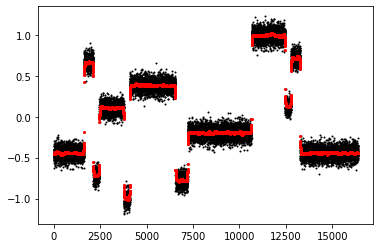

In [16]:
plt.plot(x, 'o', c='k', ms=1)
plt.plot(x_den, 'o', c='r', ms=2)
plt.show()

In [17]:
den_funcs = [savgol_filter, wiener, rolling_mean, rolling_median, direct_tvd, denoise_tv_chambolle, wavelet_denoising, wden_softSURE, DTCWTNeighCoeff]

In [18]:
den_func_names = [f.__name__ for f in den_funcs]

In [19]:
den_func_names

['savgol_filter',
 'wiener',
 'rolling_mean',
 'rolling_median',
 'direct_tvd',
 'denoise_tv_chambolle',
 'wavelet_denoising',
 'wden_softSURE',
 'DTCWTNeighCoeff']

In [20]:
import itertools
wlens = [16, 32, 64, 128, 256]
odd_wlens = [w-1 for w in wlens]
orders = [2, 3, 5, 7]
coeff_levels = [0, 1, 2, 3, 4, 5]
wavelets = ['db4', 'db8', 'sym4', 'sym8']
weights = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 15, 20]

savgol_params = list(itertools.product(odd_wlens, orders))
wavelet_params = list(itertools.product(wavelets, [1, 2, 3, 4, 5]))
func_params = {
    'savgol_filter': savgol_params,
    'wiener': wlens,
    'rolling_mean': wlens,
    'rolling_median': wlens,
    'direct_tvd': weights,
    'denoise_tv_chambolle': weights,
    'wavelet_denoising': wavelet_params,
    'wden_softSURE': wavelet_params,
    'DTCWTNeighCoeff': coeff_levels
}

In [21]:
from collections.abc import Iterable
for f in den_funcs:
    f_name = f.__name__
    params = func_params[f_name]
    for p in params:
        if isinstance(p, Iterable):
            x_den = f(x, *p)
            print(f_name + '_' + '_'.join([str(a) for a in p]))
        else:
            x_den = f(x, p)
            print(f_name + '_' + str(p))
        

savgol_filter_15_2
savgol_filter_15_3
savgol_filter_15_5
savgol_filter_15_7
savgol_filter_31_2
savgol_filter_31_3
savgol_filter_31_5
savgol_filter_31_7
savgol_filter_63_2
savgol_filter_63_3
savgol_filter_63_5
savgol_filter_63_7
savgol_filter_127_2
savgol_filter_127_3
savgol_filter_127_5
savgol_filter_127_7
savgol_filter_255_2
savgol_filter_255_3
savgol_filter_255_5
savgol_filter_255_7
wiener_16
wiener_32
wiener_64
wiener_128
wiener_256
rolling_mean_16
rolling_mean_32
rolling_mean_64
rolling_mean_128
rolling_mean_256
rolling_median_16
rolling_median_32
rolling_median_64
rolling_median_128
rolling_median_256
direct_tvd_0.001
direct_tvd_0.01
direct_tvd_0.1
direct_tvd_0.25
direct_tvd_0.5
direct_tvd_0.75
direct_tvd_1
direct_tvd_2
direct_tvd_5
direct_tvd_10
direct_tvd_15
direct_tvd_20
denoise_tv_chambolle_0.001
denoise_tv_chambolle_0.01
denoise_tv_chambolle_0.1
denoise_tv_chambolle_0.25
denoise_tv_chambolle_0.5
denoise_tv_chambolle_0.75
denoise_tv_chambolle_1
denoise_tv_chambolle_2
denoise_t

/home/trevor/.local/lib/python3.8/site-packages/pyyawt/dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


wden_softSURE_sym4_2
wden_softSURE_sym4_3
wden_softSURE_sym4_4
wden_softSURE_sym4_5
wden_softSURE_sym8_1
wden_softSURE_sym8_2
wden_softSURE_sym8_3
wden_softSURE_sym8_4
wden_softSURE_sym8_5
DTCWTNeighCoeff_0
DTCWTNeighCoeff_1
DTCWTNeighCoeff_2
DTCWTNeighCoeff_3
DTCWTNeighCoeff_4
DTCWTNeighCoeff_5


In [22]:
sqrt_snr = 2  # 0.5, 2, 8
t, clean_sig, noisy_sig = generate_test_signals(sig_len=14, sqrt_snr=sqrt_snr)

In [23]:
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import peak_signal_noise_ratio as PSNR
import time

results = {}
denoised_signals = {}
for sig_name, x in noisy_sig.items():
    df_res = pd.DataFrame()
    x_clean = clean_sig[sig_name]
    for f in den_funcs:
        # Get function and run denoising
        f_name = f.__name__
        params = func_params[f_name]
        for p in params:
            if isinstance(p, Iterable):
                ts_now = time.time()
                x_den = f(x, *p)
                ts_done = time.time()
                func_param_name = f_name + '_' + '_'.join([str(a) for a in p])
            else:
                ts_now = time.time()
                x_den = f(x, p)
                ts_done = time.time()
                func_param_name = f_name + '_' + str(p)
            # Get stats
            denoised_signals.setdefault(sig_name, {}).update({func_param_name: x_den})
            runtime = ts_done - ts_now
            data_range = int(np.max(x_clean) - np.min(x_clean))
            psnr = PSNR(x_clean, x_den, data_range=data_range)
            mse = MSE(x_clean, x_den)
            stat_dict = {'func_name': f.__name__,
                        'func_params': func_param_name,
                        'mse': mse,
                        'psnr': psnr,
                        'runtime_ms': runtime}
            df_res = df_res.append(stat_dict, ignore_index=True)
    results.update({sig_name: df_res})
    print(sig_name + ' done')

        

blocks done
bumps done
heavy sine done
square_wave done
sawtooth_wave done
simple_sine done
sum_sine done
poly_cosine done


In [24]:
df = results['square_wave']
df.sort_values(by='psnr', ascending=False).groupby(by=['func_name']).head(1)

,func_name,func_params,mse,psnr,runtime_ms
44,direct_tvd,direct_tvd_10,0.002724,31.668397,0.068264
99,DTCWTNeighCoeff,DTCWTNeighCoeff_0,0.012516,25.046004,0.274841
93,wden_softSURE,wden_softSURE_sym4_5,0.014630,24.368290,0.003603
22,wiener,wiener_64,0.015137,24.220202,0.001042
55,denoise_tv_chambolle,denoise_tv_chambolle_5,0.015802,24.033557,0.006730
31,rolling_median,rolling_median_32,0.017117,23.686262,0.513089
26,rolling_mean,rolling_mean_32,0.020255,22.955255,0.112290
9,savgol_filter,savgol_filter_63_3,0.020748,22.850927,0.000861
70,wavelet_denoising,wavelet_denoising_sym4_2,0.026700,21.755538,0.000784


In [25]:
df_ranks = pd.DataFrame()
for k in results.keys():
    df = results[k]
    df_top = df.sort_values(by='mse').groupby(by=['func_name']).head(1).reset_index(drop=True)
    df_top['rank'] = df_top.index + 1
    df_top['signal'] = k
    df_ranks = df_ranks.append(df_top, ignore_index=True)

In [26]:
df_ranks.sort_values('rank').head(20)

,func_name,func_params,mse,psnr,runtime_ms,rank,signal
0,direct_tvd,direct_tvd_5,0.000593,38.293302,0.066081,1,blocks
54,wavelet_denoising,wavelet_denoising_db8_5,0.000255,41.961779,0.000924,1,sum_sine
45,wavelet_denoising,wavelet_denoising_sym4_4,0.000361,40.448773,0.000830,1,simple_sine
36,rolling_mean,rolling_mean_128,0.000752,31.240332,0.104817,1,sawtooth_wave
27,direct_tvd,direct_tvd_10,0.002724,31.668397,0.068264,1,square_wave
18,direct_tvd,direct_tvd_5,0.000717,37.464287,0.132162,1,heavy sine
9,direct_tvd,direct_tvd_5,0.002659,31.772790,0.101435,1,bumps
63,savgol_filter,savgol_filter_255_3,0.001141,29.426417,0.002109,1,poly_cosine
28,DTCWTNeighCoeff,DTCWTNeighCoeff_0,0.012516,25.046004,0.274841,2,square_wave
1,DTCWTNeighCoeff,DTCWTNeighCoeff_0,0.002513,32.017842,0.292672,2,blocks


In [27]:
df_ranks.loc[df_ranks['func_name'] == 'direct_tvd', ['func_name', 'signal', 'mse']]

,func_name,signal,mse
0,direct_tvd,blocks,0.000593
9,direct_tvd,bumps,0.002659
18,direct_tvd,heavy sine,0.000717
27,direct_tvd,square_wave,0.002724
39,direct_tvd,sawtooth_wave,0.001453
50,direct_tvd,simple_sine,0.001798
60,direct_tvd,sum_sine,0.001002
71,direct_tvd,poly_cosine,0.005406


In [28]:
df_ranks.loc[df_ranks['func_name'] == 'wavelet_denoising', ['func_name', 'signal', 'mse']]

,func_name,signal,mse
4,wavelet_denoising,blocks,0.003546
15,wavelet_denoising,bumps,0.005457
22,wavelet_denoising,heavy sine,0.000982
35,wavelet_denoising,square_wave,0.026700
40,wavelet_denoising,sawtooth_wave,0.001459
45,wavelet_denoising,simple_sine,0.000361
54,wavelet_denoising,sum_sine,0.000255
64,wavelet_denoising,poly_cosine,0.001948


In [29]:
df_ranks.groupby('func_name')['mse'].agg(['mean', 'std']).sort_values(by='mean')

,mean,std
func_name,,
direct_tvd,0.002044,0.001581
DTCWTNeighCoeff,0.003615,0.003753
rolling_median,0.003942,0.005502
rolling_mean,0.004050,0.006711
savgol_filter,0.004066,0.006890
wiener,0.004119,0.004835
denoise_tv_chambolle,0.004699,0.004637
wden_softSURE,0.004744,0.004205
wavelet_denoising,0.005088,0.008906


In [30]:
yerr = df_ranks.groupby('func_name')['mse'].agg(['mean', 'std']).sort_values(by='mean')['std'].values

<AxesSubplot:title={'center':'Reconstruction error for signals, SNR = 4'}, xlabel='Denoising function', ylabel='MSE'>

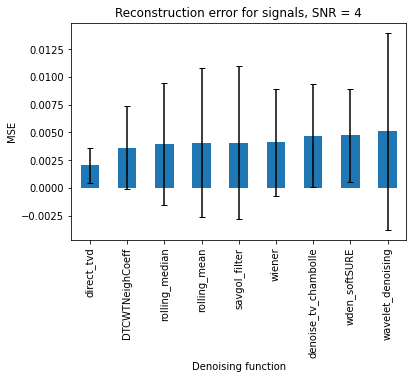

In [31]:
df_ranks.groupby('func_name')['mse'].agg('mean').sort_values().plot.bar(yerr=yerr, capsize=3,
    title=f'Reconstruction error for signals, SNR = {sqrt_snr ** 2}',
    xlabel='Denoising function',
    ylabel='MSE')

In [32]:
from scipy.stats import ttest_ind
a = df_ranks.loc[df_ranks['func_name'] == 'direct_tvd', 'mse'].values
b = df_ranks.loc[df_ranks['func_name'] == 'denoise_tv_chambolle', 'mse'].values
ttest_ind(a, b, equal_var=False)

Ttest_indResult(statistic=-1.5325064285697942, pvalue=0.1612909272852116)

In [33]:
print(f"SNR = {sqrt_snr ** 2}")
for fname1, fname2 in itertools.combinations(den_func_names, 2):
    a = df_ranks.loc[df_ranks['func_name'] == fname1, 'mse'].values
    b = df_ranks.loc[df_ranks['func_name'] == fname2, 'mse'].values
    res = ttest_ind(a, b, equal_var=False)
    if res.pvalue < 0.05:
        print(f"{fname1} -- {fname2}, p-value = {res.pvalue:.4f}")

SNR = 4


In [34]:
df_ranks.loc[df_ranks['rank'] <=3, ['signal', 'func_params', 'rank', 'mse']]

,signal,func_params,rank,mse
0,blocks,direct_tvd_5,1,0.000593
1,blocks,DTCWTNeighCoeff_0,2,0.002513
2,blocks,rolling_median_64,3,0.003192
9,bumps,direct_tvd_5,1,0.002659
10,bumps,savgol_filter_255_2,2,0.002848
11,bumps,rolling_mean_64,3,0.003218
18,heavy sine,direct_tvd_5,1,0.000717
19,heavy sine,rolling_mean_256,2,0.000748
20,heavy sine,savgol_filter_255_2,3,0.000862
27,square_wave,direct_tvd_10,1,0.002724


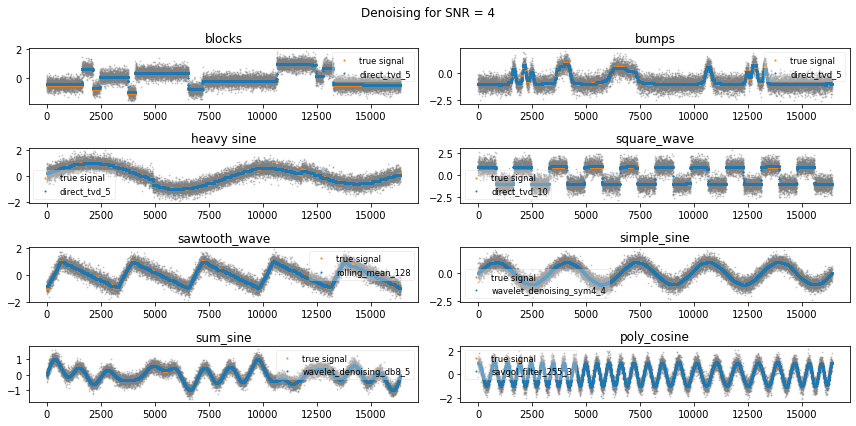

In [52]:
fig, axs = plt.subplots(4, 2, figsize=(12, 6))
axs = axs.flatten()

for ax, signal in zip(axs, noisy_sig.keys()):
    ax.plot(noisy_sig[signal], 'o', color='grey', ms=1, alpha=0.3)
    func_names = df_ranks.loc[(df_ranks['rank'] <=1) & (df_ranks['signal'] == signal), ['func_params']].values.flatten()
    for name in func_names:
        x_den = denoised_signals[signal][name]
        ax.plot(clean_sig[signal], 'o', c='C1', ms=1, label='true signal')
        ax.plot(x_den, 'o', ms=1, c='C0', label=name)
    ax.legend(framealpha=0.3, fontsize='small')
    ax.set_title(signal)
plt.suptitle(f'Denoising for SNR = {sqrt_snr ** 2}')
plt.tight_layout()
plt.show()


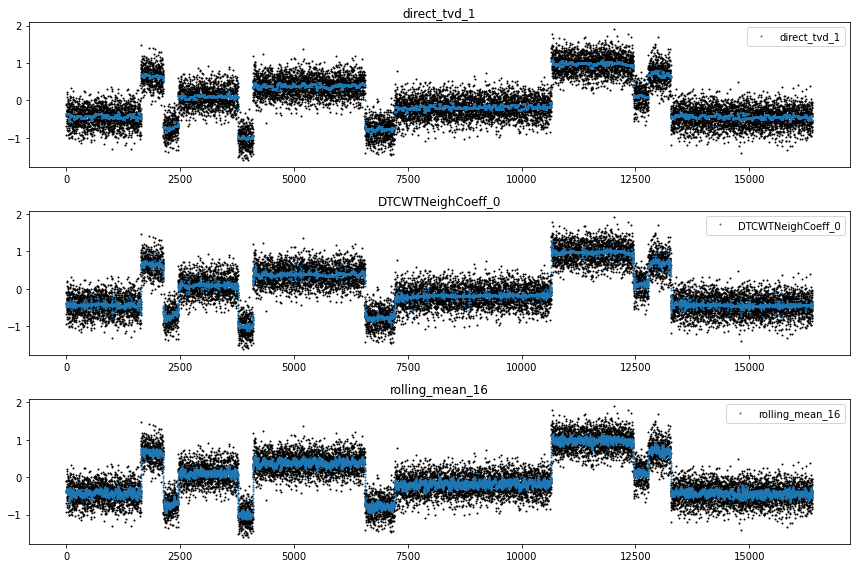

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

algos = ['direct_tvd_1', 'DTCWTNeighCoeff_0', 'rolling_mean_16']
signal = 'blocks'

for ax, algo in zip(axs, algos):
    ax.plot(noisy_sig[signal], 'o', color='k', ms=1)
    x_den = denoised_signals[signal][algo]
    ax.plot(x_den, 'o', ms=1, label=algo)
    ax.legend()
    ax.set_title(algo)
plt.tight_layout()
plt.show()